# Determining Car Prices

The "Non-Accident, Non-Painted" used car sales service aims to provide its customers with an efficient and accurate way to estimate the market value of their vehicles. By leveraging historical data on car technical specifications, configurations, and prices, we can develop a reliable model to predict car prices. This will not only attract new customers to the platform but also enhance their overall experience by providing valuable insights into their car's market value.

**Features**


`DateCrawled`: The date the car listing was crawled from the database.

`VehicleType`: The type of car body (e.g., sedan, hatchback, SUV).

`RegistrationYear`: The year the car was registered.

`Gearbox`: The type of gearbox (e.g., manual, automatic).

`Power`: The power of the car in horsepower (hp).

`Model`: The model of the car.

`Kilometer`: The mileage of the car in kilometers (km).

`RegistrationMonth`: The month the car was registered.

`FuelType`: The type of fuel the car uses (e.g., gasoline, diesel).

`Brand`: The brand of the car.

`Repaired`: Indicates whether the car has been repaired (Yes/No).

`DateCreated`: The date the listing was created.

`NumberOfPictures`: The number of pictures of the car in the listing.

`PostalCode`: The postal code of the user who created the listing.

`LastSeen`: The date of the user's last activity on the platform.

**Target**

`Price`: The price of the car in euros.

## Pre-processing

### Import libraries

In [1]:
!pip install xgboost

In [2]:
pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 5.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install catboost

In [4]:
!pip install missingno

In [5]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
from tqdm.notebook import tqdm_notebook as tqdm
import time
from catboost import CatBoostRegressor, Pool
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

RANDOM_STATE = 42
warnings.filterwarnings("ignore")

### Data loading

In [6]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net///datasets/autos.csv')

### Helper functions

In [7]:
#Data Information

def get_data_info(data):
    display(data.sample(5))  # Display 5 random samples from the dataset
    display(data.info())  # Display information about the dataset, including data types and non-null counts
    display(data.describe(include='all'))  # Display summary statistics for all columns in the dataset


#Missing Values 

def get_numerical_summary(data):
    total = data.shape[0]  # Total number of rows in the dataset
    missing_columns = [col for col in data.columns if data[col].isnull().sum() > 0]  # Columns with missing values
    missing_percent = {}
    for col in missing_columns:
        null_count = data[col].isnull().sum()  # Count of missing values in the column
        per = (null_count / total) * 100  # Percentage of missing values in the column
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))  # Display the column name, null count, and percentage
    else:
        print('No missing values')


#Visualization


def show_hist(df, col, bins=100, xlim=None, ylim=None, figsize=None,
              title='Distribution of Values',
              xlabel=None, ylabel='Number of Values'):

    _, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                      gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)

    if col in df.columns:
        sns.boxplot(x=df[col], ax=ax_box)  # Boxplot for visualizing outliers
        sns.histplot(df[col], ax=ax_hist, bins=bins, kde=True)  # Histogram for visualizing distribution
        if xlabel is None:
            xlabel = col
        ax_box.set(xlabel='')  # To avoid duplication of x-label
        ax_hist.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)  # Set x-label, y-label, and axis limits
        ax_hist.grid(visible=True)  # Display gridlines on the histogram
        plt.suptitle(title, y=0.92, fontsize=14)  # Set the title of the plot
    else:
        print('Column', col, 'not found')

### Dataset info

In [8]:
get_data_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
281548,2016-03-16 20:42:22,850,coupe,1997,manual,101,a3,150000,12,petrol,audi,NaN,2016-03-16 00:00:00,0,44269,2016-03-17 19:19:12
268552,2016-04-01 06:36:24,300,NaN,2017,manual,55,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,23564,2016-04-07 06:15:28
111118,2016-03-05 14:11:41,6999,sedan,2003,auto,170,5er,150000,12,petrol,bmw,no,2016-03-03 00:00:00,0,35684,2016-03-20 22:17:34
62827,2016-03-12 16:47:08,600,sedan,1999,manual,245,5er,150000,10,petrol,bmw,yes,2016-03-12 00:00:00,0,45663,2016-03-12 16:47:08
92271,2016-03-29 14:46:50,900,wagon,2002,manual,101,3_reihe,150000,6,gasoline,mazda,no,2016-03-29 00:00:00,0,64395,2016-03-31 07:18:12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [9]:
get_numerical_summary(data)

VehicleType : 37490 (10.579%)
Gearbox : 19833 (5.597%)
Model : 19705 (5.561%)
FuelType : 32895 (9.283%)
Repaired : 71154 (20.079%)
No missing values


#### Identified Issues:

     Date Format Issue: The date format is not correct. While we could format the data, these features are not necessary for price analysis. We will remove them in further steps.

    Anomalous Registration Year Values: There are anomalous values in the registration year of the cars. Cars cannot be registered in the year 9999 or 1000.

    Anomalous Power and Price Values: Anomalies are also observed in the "Power" and "Price" columns. Values cannot be zero.

    Column Names: The column names should be formatted in lowercase for consistency.

    Missing Values in "Repaired" Column: There are many missing values in the "Repaired" column. We need to fill them.

#### Correlation

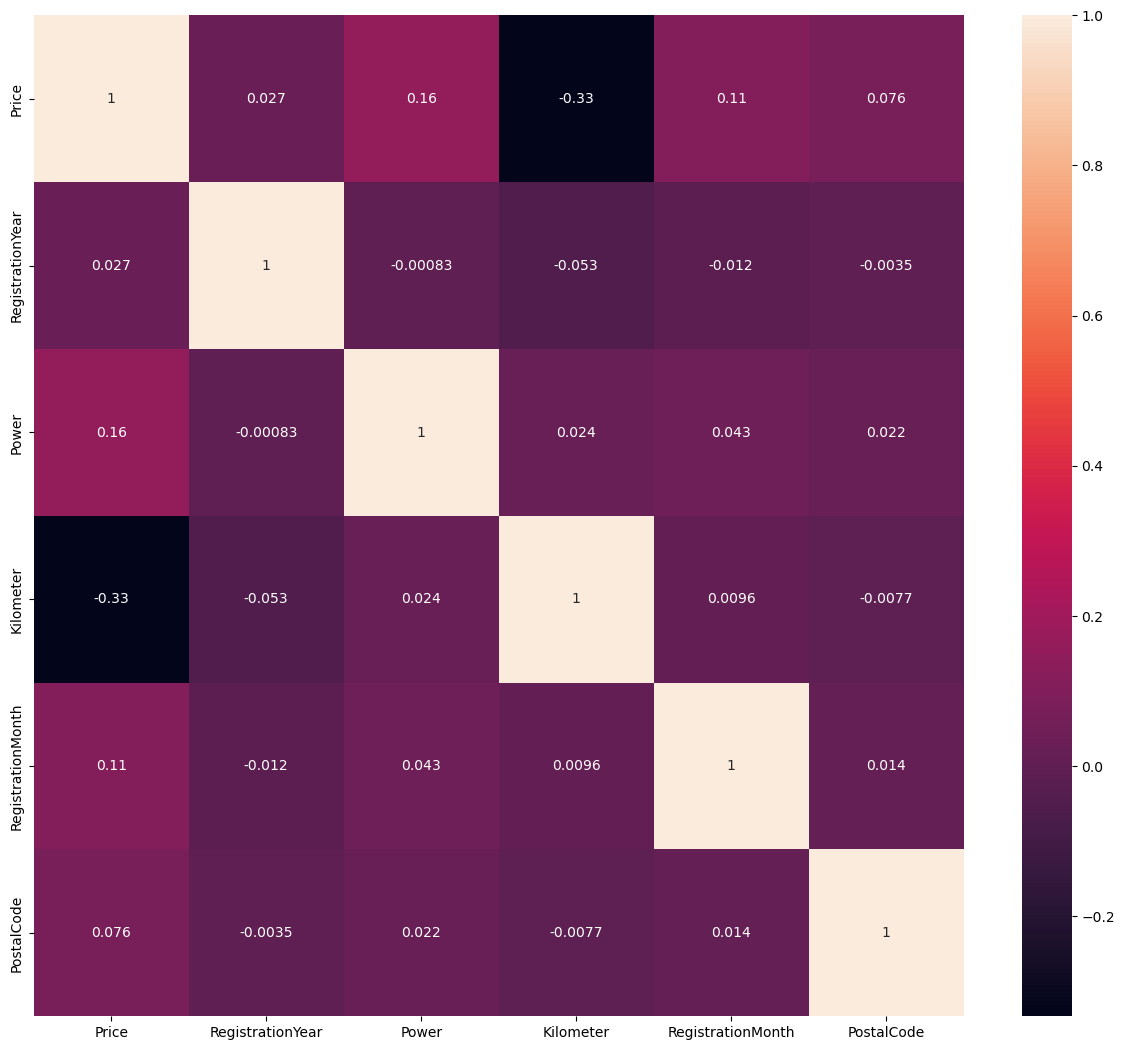

In [10]:
plt.figure(figsize=(15, 13))
data_heatmap = data.drop(['NumberOfPictures'], axis=True)
sns.heatmap(data_heatmap.corr(), annot=True);

The Pearson correlation index among the features falls within an acceptable range. This indicates that the interrelation between the features is not expected to significantly affect the training of the linear regression model.

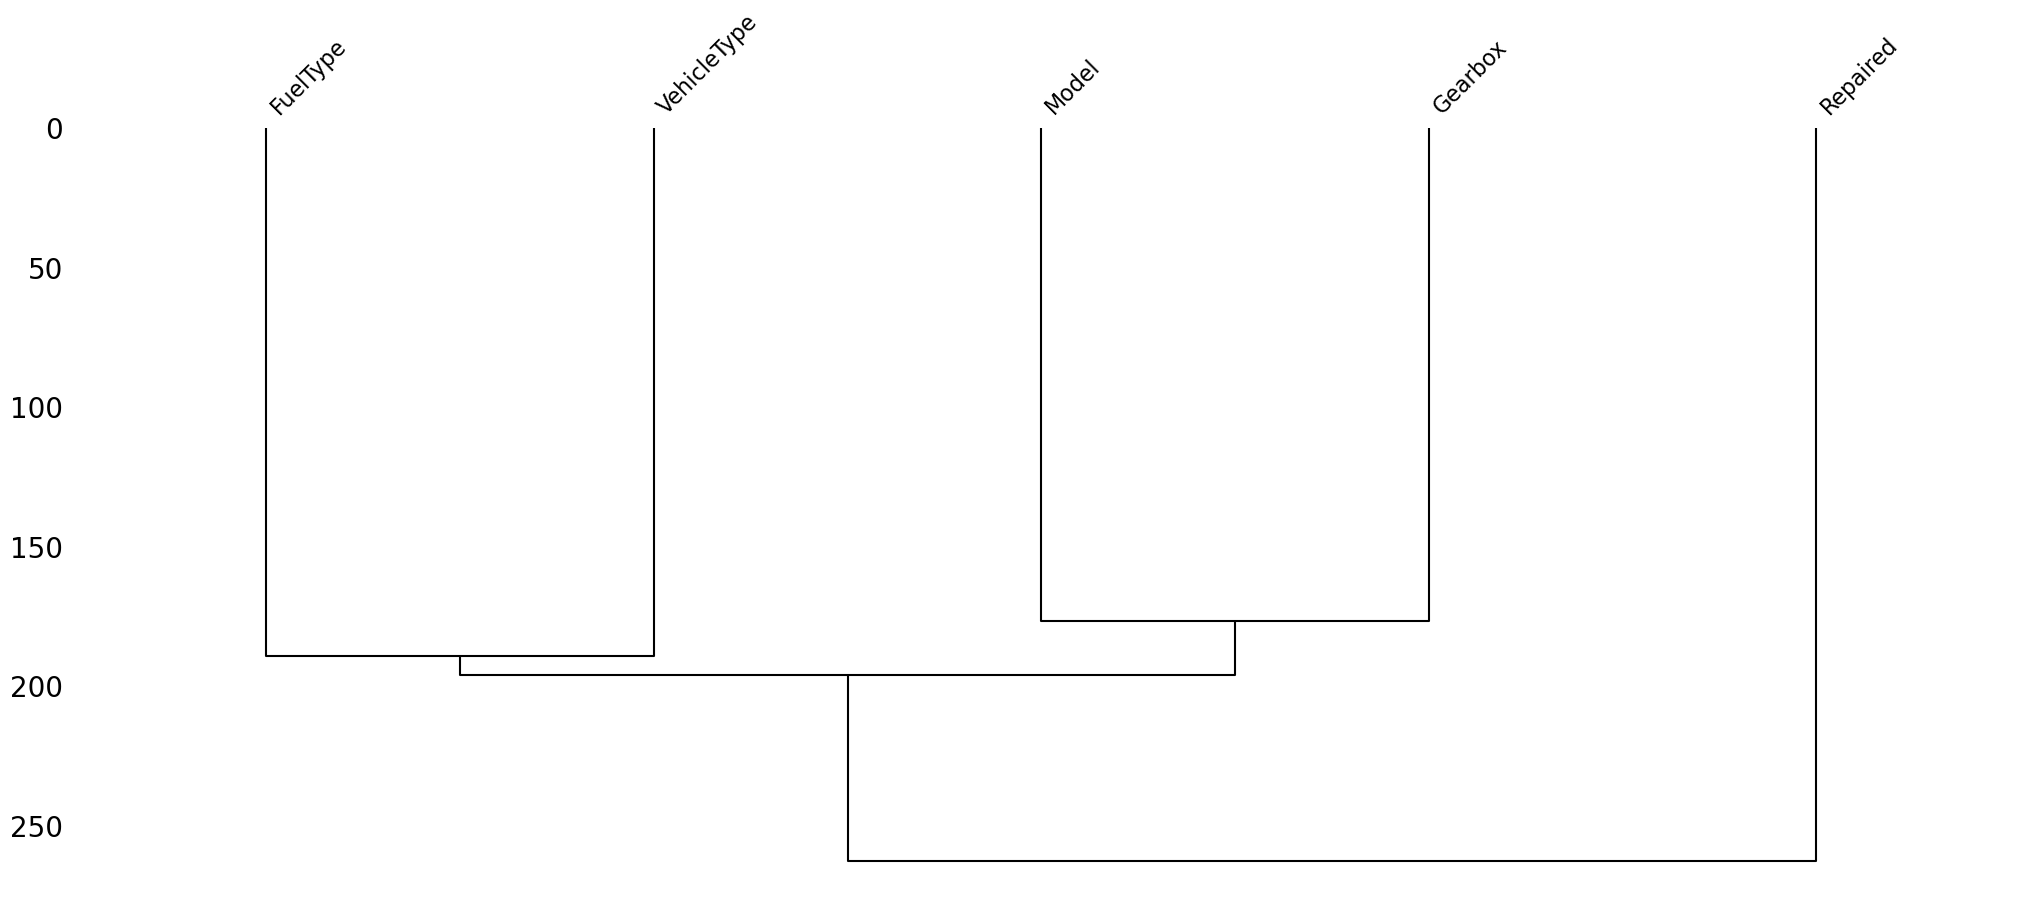

In [11]:
missing_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
msno.dendrogram(data[missing_columns]);

The dendrogram shows the hierarchical relationship between the columns based on their missing values. It utilizes a hierarchical clustering algorithm based on the correlation between the missing values of the columns. We observe that there is no strong dependency between the features with missing values. Therefore, they do not significantly influence each other.

### Data Processing

In [12]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures', 'RegistrationMonth'], axis=1)

In [13]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Anomalies

In [14]:
get_data_info(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
68072,1770,sedan,1999,auto,170,omega,150000,lpg,opel,no
225785,1700,NaN,2017,manual,109,2_reihe,150000,NaN,peugeot,no
85478,199,sedan,2015,manual,136,1er,20000,petrol,bmw,no
204808,4250,wagon,2003,manual,136,touran,150000,gasoline,volkswagen,NaN
242692,1500,bus,1999,auto,116,zafira,150000,petrol,opel,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
count,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,321474,354369,283215
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,29232,NaN,216352,77013,247161
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,NaN,NaN,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN


14600.0

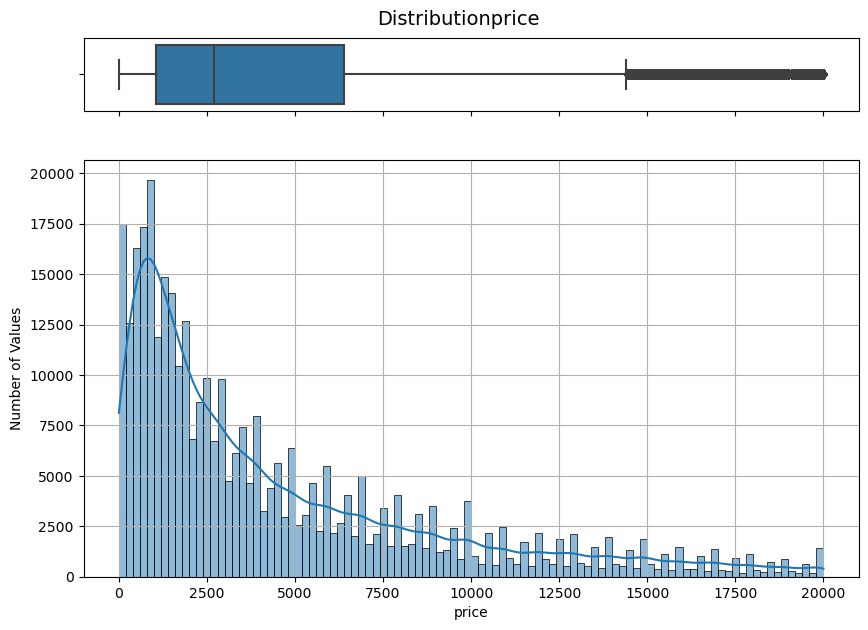

In [15]:
raw = 'price'
show_hist(data, raw, bins=100,  figsize=(10, 7), title='Distribution'+raw)
data[raw].quantile(0.95)

Here we can observe that there are anomalous values in the "price" feature, which are close to zero. These values need to be removed from the dataset to avoid distorting the analysis and modeling process.

66


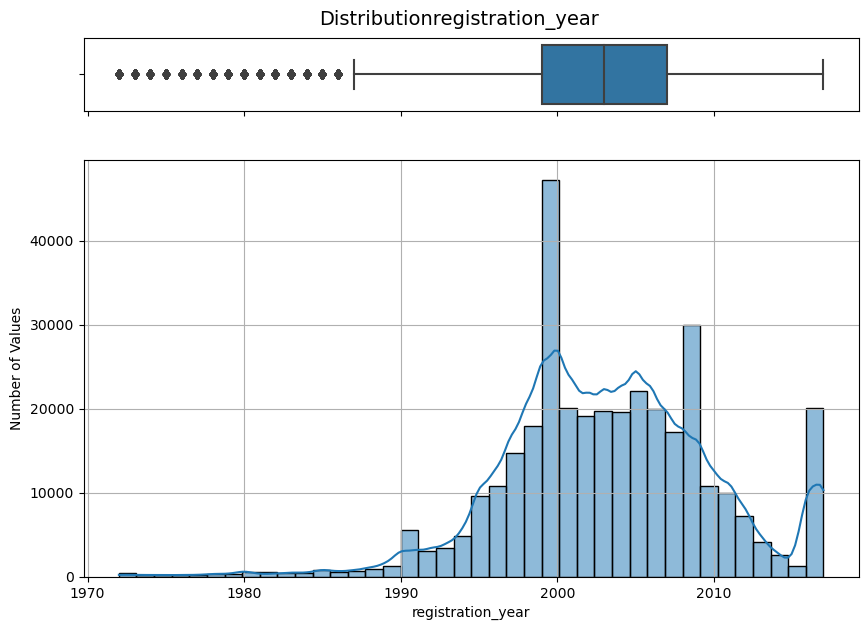

In [16]:
raw = 'registration_year'
print((data[raw] < 1900).sum())
show_hist(data[(data[raw] > data[raw].quantile(.005)) & (data[raw] < data[raw].quantile(.995))],
          raw, bins=40, figsize=(10, 7), title='Distribution'+raw)


There are 66 anomalous values in the dataset. The majority of the values are distributed between the years 1990 and 2010, which could indicate that these values are more representative of the actual data. Removing the anomalies will help improve the accuracy of the analysis and modeling process.

40225


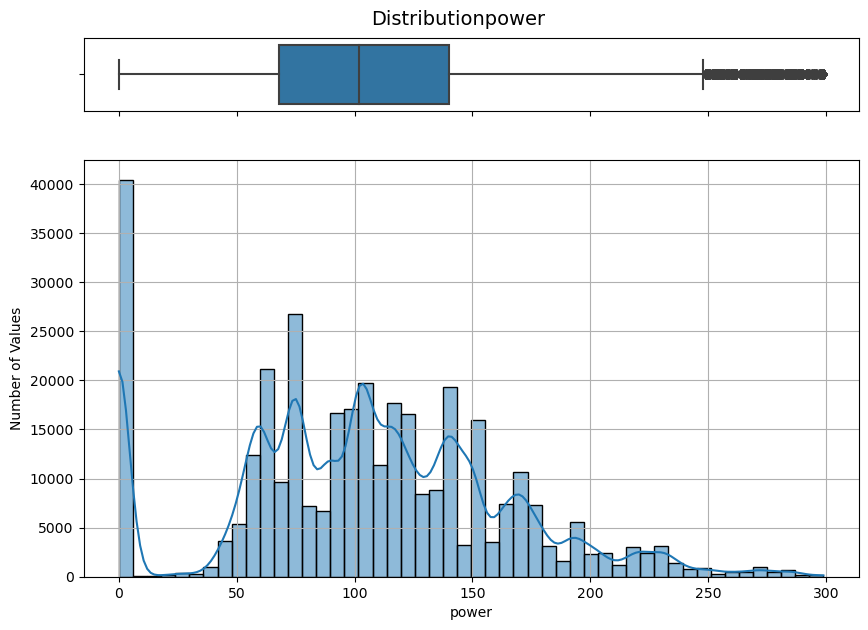

In [17]:
raw = 'power'
print((data[raw] == 0).sum())
show_hist(data[data[raw] < data[raw].quantile(.99)],
          raw, bins=50,  figsize=(10, 7), title='Distribution'+raw)

Indeed, there are 4025 rows with a price equal to zero. It is crucial to filter out these rows because zero prices are invalid and can distort the analysis and modeling results. Removing these rows will ensure the accuracy and reliability of our analysis and predictions for determining the prices of cars.

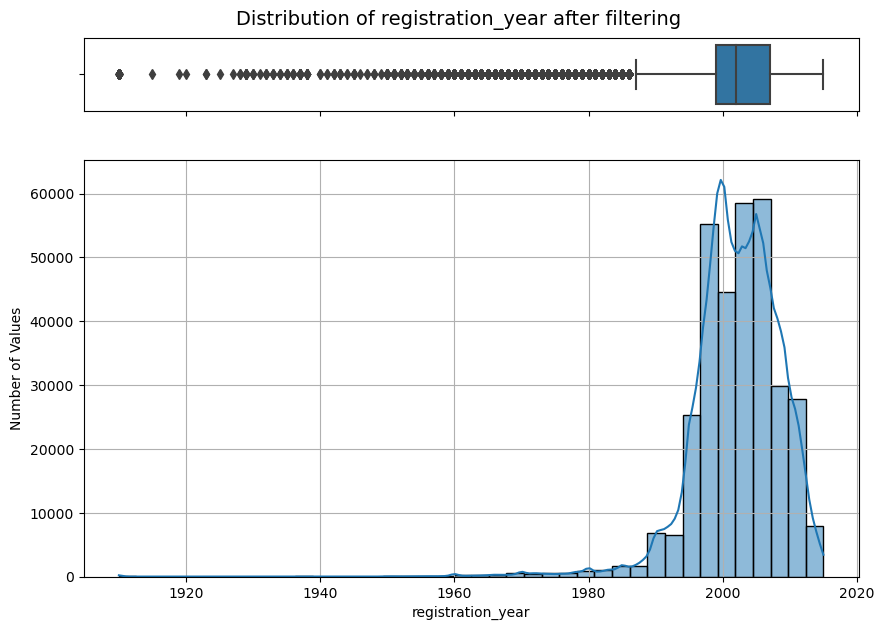

In [18]:
#Removing anomalous values in the car registration year
upd = 'registration_year'
data = data.loc[(data['registration_year'] > 1900) & (data['registration_year'] < 2016)]
show_hist(data, upd, bins=40, figsize=(10, 7), title='Distribution of ' + upd + ' after filtering')

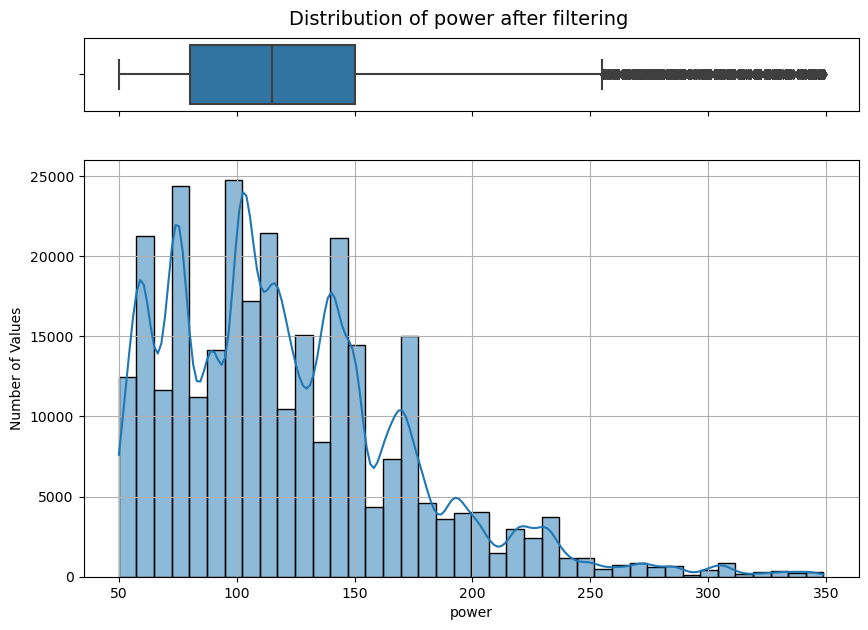

In [19]:
upd = 'power'
data = data.query('50 <= power < 350')
show_hist(data, upd, bins=40, figsize=(10, 7),  title='Distribution of ' + upd + ' after filtering')

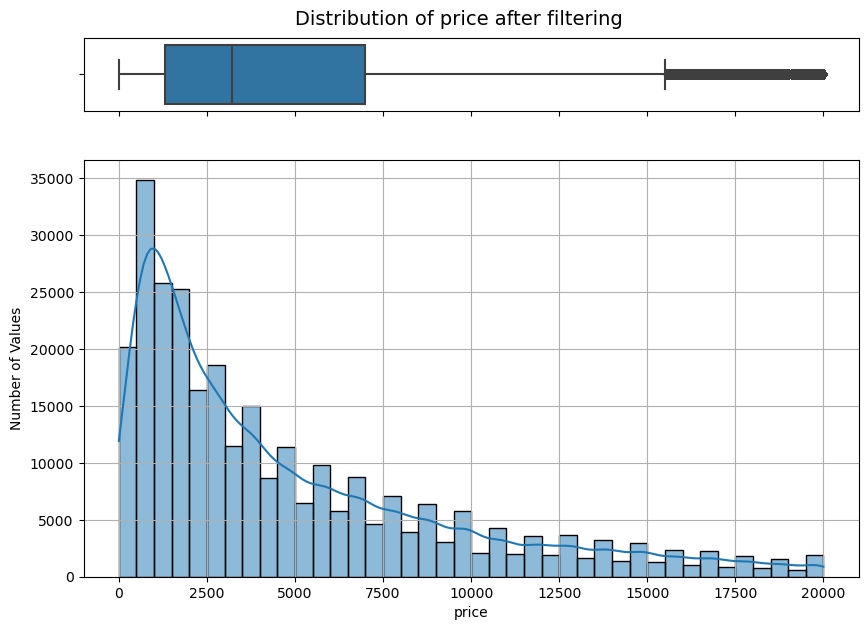

In [20]:
upd = 'price'
data = data.query('0 <= price')
show_hist(data, upd, bins=40, figsize=(10, 7),  title='Distribution of ' + upd + ' after filtering')

### Filling missing values

The main question is why there are so many missing values in the "Repaired" column. One hypothesis is that users did not indicate any repairs for their cars because the cars were not repaired (they might be new cars). Let's examine the registration year of the cars with missing values in the "Repaired" column.

In [21]:
data.loc[data['repaired'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,NaN
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354341,699,sedan,1999,manual,101,vectra,150000,petrol,opel,NaN
354349,5999,wagon,2005,manual,140,a4,150000,gasoline,audi,NaN
354356,999,convertible,2000,manual,95,megane,150000,petrol,renault,NaN
354357,1690,wagon,2004,manual,55,fabia,150000,petrol,skoda,NaN


Indeed, it seems unlikely that cars from 1995 or 2000 have never been repaired. Users might have forgotten to specify the repairs, or intentionally omitted this information to increase the chances of selling their cars. It's possible that users left the question "Has the car been repaired?" unanswered because it has not been repaired. Since we don't have access to the original data providers to confirm the reasons for the missing values, we can fill them with 0 to indicate that these cars have not been repaired.

We will identify the categorical features and take a look at their value distributions. Then, we will proceed to fill in the missing values for these features.

In [22]:
data['repaired'] = data['repaired'].replace({'yes': 1, 'no': 0})

In [23]:
def fillna_with_mode(data, target_col, group_col):
    before = data[target_col].isna().sum()
    data.loc[data[target_col].isna(), target_col] = (
        data.loc[data[target_col].isna(), group_col].map(
            data.groupby(group_col)[target_col].agg(lambda x: pd.Series.mode(x)[0]))
    )
    print('{} out of {} values are filled with the most occurring "{}" among "{}"'
        .format(before-data[target_col].isna().sum(), before, target_col, group_col))

In [24]:
for f in ['vehicle_type', 'gearbox', 'fuel_type']:
    print('"{}" :'.format(f))
    fillna_with_mode(data, f, 'model')
    fillna_with_mode(data, f, 'brand')
    print()
data['model'].fillna('_unknown', inplace=True)
data['repaired'].fillna('0', inplace=True)

"vehicle_type" :
4289 out of 5173 values are filled with the most occurring "vehicle_type" among "model"
884 out of 884 values are filled with the most occurring "vehicle_type" among "brand"

"gearbox" :
4184 out of 4827 values are filled with the most occurring "gearbox" among "model"
643 out of 643 values are filled with the most occurring "gearbox" among "brand"

"fuel_type" :
11035 out of 13379 values are filled with the most occurring "fuel_type" among "model"
2344 out of 2344 values are filled with the most occurring "fuel_type" among "brand"



In [25]:
data['repaired'] = data['repaired'].astype('int')

In [26]:
get_numerical_summary(data)

No missing values


In [27]:
get_data_info(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
212672,1980,wagon,1999,auto,170,e_klasse,150000,petrol,mercedes_benz,0
167279,1199,sedan,1997,manual,116,3er,150000,petrol,bmw,0
203290,2500,wagon,2004,manual,90,focus,150000,gasoline,ford,0
152089,899,small,2003,manual,75,ibiza,150000,petrol,seat,1
229973,700,small,1999,manual,50,arosa,150000,petrol,seat,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 289882 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289882 non-null  int64 
 1   vehicle_type       289882 non-null  object
 2   registration_year  289882 non-null  int64 
 3   gearbox            289882 non-null  object
 4   power              289882 non-null  int64 
 5   model              289882 non-null  object
 6   kilometer          289882 non-null  int64 
 7   fuel_type          289882 non-null  object
 8   brand              289882 non-null  object
 9   repaired           289882 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 24.3+ MB


None

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
count,289882.000000,289882,289882.000000,289882,289882.000000,289882,289882.000000,289882,289882,289882.000000
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,NaN
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,NaN
freq,NaN,86646,NaN,231397,NaN,24442,NaN,194872,62483,NaN
mean,4839.652107,NaN,2002.611366,NaN,121.667644,NaN,128452.077052,NaN,NaN,0.098526
std,4616.466003,NaN,6.112185,NaN,51.087895,NaN,36620.325216,NaN,NaN,0.298025
min,0.000000,NaN,1910.000000,NaN,50.000000,NaN,5000.000000,NaN,NaN,0.000000
25%,1300.000000,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,NaN,NaN,0.000000
50%,3200.000000,NaN,2003.000000,NaN,115.000000,NaN,150000.000000,NaN,NaN,0.000000
75%,6999.000000,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,0.000000


## Model Training


We have selected 4 models for testing: Ridge, Decision Tree Regressor, Cat Boost Regressor, and XGB Regressor

### We are splitting the dataset into training and testing sets

In [28]:
features = data.drop(['price'], axis=1)
target = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

### Encoding

In [29]:
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)


['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']


In [30]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('repaired')
num_features

['registration_year', 'power', 'kilometer']

#### Ordinal Encoder

In [31]:

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ohe_features_ridge
encoder.fit(X_train[cat_columns])

features_train_ord = X_train.copy()

features_test_ord = X_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])

features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [32]:
(features_train_ord.columns != features_test_ord.columns).sum()

0

#### One Hot Encoder

In [33]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [34]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)


encoder_ohe.fit(X_train_ridge[ohe_features_ridge])


X_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])


X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)


scaler = StandardScaler()


X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])


X_train_ridge.head()

,registration_year,power,kilometer,repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
206328,0.716679,1.220184,-0.776457,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22499,-0.592616,-0.913920,-0.094002,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289743,0.389355,0.809027,0.588453,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-1.247263,-0.385289,0.588453,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170546,-0.265292,1.396395,0.588453,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:

X_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_ridge[ohe_features_ridge])

X_test_ridge = X_test_ridge.drop(ohe_features_ridge, axis=1)

X_test_ridge[num_features] = scaler.transform(
    X_test_ridge[num_features]
)


X_test_ridge.head()

,registration_year,power,kilometer,repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
153020,0.880341,-0.150341,0.588453,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272718,0.880341,-0.913920,-1.049439,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84071,-0.101630,-0.913920,0.588453,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
262192,-0.265292,-0.620236,0.588453,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281138,0.225694,-0.913920,-1.049439,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:

(X_train_ridge.columns != X_test_ridge.columns).sum()

0

### Ridge

In [37]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)


param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(X_train_ridge, y_train)


print(f'best_score: {gs_ridge.best_score_ * -1}')


print(f'best_params: {gs_ridge.best_params_}')

/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dariadzhioeva/anaconda3/lib/python3.10/site-packages/skle

best_score: 2591.7996565859844
best_params: {'alpha': 0.2}
CPU times: user 5.2 s, sys: 2.76 s, total: 7.96 s
Wall time: 2min 30s


The best RMSE score achieved is 2591.7 with the alpha parameter set to 0.2.

### A function to calculate RMSE and hyperparameters

In [38]:
common_cbr_params = {'loss_function': 'RMSE',
                     'random_state': RANDOM_STATE, 
                     'verbose': False,
                     'n_estimators': 500}

In [39]:
def best_cv_models(grid, count):




    print('Estimator: {}'.format(grid.estimator))
    print('Tested {} models on {} folds'.format(len(grid.cv_results_['params']), grid.cv))
    print('Best RMSE = {}\n'.format((-grid.best_score_) ** 0.5))
    best_idx = grid.cv_results_['rank_test_score'].argsort()[:count]
    return pd.DataFrame({
            
            'RMSE train': (-grid.cv_results_['mean_train_score'][best_idx])**0.5,
            'fit time, s': grid.cv_results_['mean_fit_time'][best_idx],
            'score time, s': grid.cv_results_['mean_score_time'][best_idx]}
        ).join(pd.DataFrame([grid.cv_results_['params'][i] for i in best_idx]))


common_cv_params = {'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 4}

### Decision Tree Regressor

In [40]:
%%time
params = {'max_depth': range(10, 51, 10),
          'min_samples_split': range(20, 101, 20),
          'min_samples_leaf': range(5, 21, 5)}
grid_dt_ohe = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                           param_grid=params, n_jobs=-1,
                           **common_cv_params)
grid_dt_ohe.fit(features_train_ord, y_train)

print('DecisionTreeRegressor for OHE encoded features')
best_cv_models(grid_dt_ohe, 10)

DecisionTreeRegressor for OHE encoded features
Estimator: DecisionTreeRegressor(random_state=42)
Tested 100 models on 4 folds
Best RMSE = 1843.065705793912

CPU times: user 1.97 s, sys: 876 ms, total: 2.85 s
Wall time: 37.9 s


,RMSE train,"fit time, s","score time, s",max_depth,min_samples_leaf,min_samples_split
0,1499.665023,0.385087,0.016155,30,5,20
1,1507.394186,0.313040,0.009636,20,5,20
2,1499.654353,0.365252,0.011965,40,5,20
3,1499.654353,0.380045,0.011905,50,5,20
4,1582.268450,0.349521,0.010730,40,10,20
5,1582.268450,0.372757,0.011303,50,10,20
6,1582.271134,0.359708,0.013338,30,10,20
7,1586.027009,0.323613,0.010096,20,10,20
8,1607.125977,0.480776,0.017851,30,5,40
9,1611.114201,0.310973,0.009240,20,5,40


The best RMSE is improving on the training set to 1499 with the hyperparameters depth = 30, min_samples_leaf = 5, and min_samples_split = 20. The execution time for training is 45 seconds.

### Cat Boost Regressor

In [41]:
categorical_cols = features_train_ord.select_dtypes(include='object').columns.to_list()

In [42]:
%%time

params = {'max_depth': [8, 12],
          'learning_rate': [0.1, 0.2]}
grid_ctb = GridSearchCV(
    CatBoostRegressor(**common_cbr_params, cat_features=categorical_cols),
    param_grid=params, **common_cv_params)
grid_ctb.fit(features_train_ord, y_train)

print('CatBoostRegressor with catgorical features (CPU)')
best_cv_models(grid_ctb, 10)

CatBoostRegressor with catgorical features (CPU)
Estimator: <catboost.core.CatBoostRegressor object at 0x293ad7610>
Tested 4 models on 4 folds
Best RMSE = 1631.3053887201556

CPU times: user 6min 45s, sys: 45.1 s, total: 7min 30s
Wall time: 2min 19s


,RMSE train,"fit time, s","score time, s",learning_rate,max_depth
0,1291.171784,10.346163,0.018193,0.2,12
1,1396.592268,13.410207,0.033913,0.1,12
2,1487.195545,3.732636,0.020399,0.2,8
3,1572.366138,4.177846,0.017686,0.1,8



We have achieved a result of 1291 on the training set. The model training takes approximately 3 minutes.

## Model Analysis


The best performing models are Cat Boost Regressor and Decision Tree Regressor. Let's evaluate the Cat Boost Regressor on the test set.


In [43]:
def best_test_models(model, X_test_ridge, y_test):
    start_time = time.time()
    model.fit(features_test_ord, y_test)
    fit_time = time.time() - start_time
    y_pred = model.predict(features_test_ord)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    return {'RMSE test': rmse_test, 'fit time, s': fit_time}

catboost_params = {
    'learning_rate': 0.2,
    'depth': 12
}

tree_params = {'max_depth': 30,
          'min_samples_split': 20,
          'min_samples_leaf': 5}

catboost_model = CatBoostRegressor(**catboost_params, verbose=False)
dt = DecisionTreeRegressor(**tree_params)

catboost_result = best_test_models(catboost_model, features_test_ord, y_test)
dt_result = best_test_models(dt, features_test_ord, y_test)

results = pd.DataFrame({
    'Model Name': ['CatBoostRegressor', 'DecisionTreeRegressor'],
    'RMSE test': [catboost_result['RMSE test'], dt_result['RMSE test']],
    'fit time, s': [catboost_result['fit time, s'], dt_result['fit time, s']]
})
results

,Model Name,RMSE test,"fit time, s"
0,CatBoostRegressor,1052.094470,15.525088
1,DecisionTreeRegressor,1551.925949,0.133302


After conducting a thorough analysis and testing various models, we have identified the top performers for predicting the market value of used cars. The CatBoostRegressor, with ordinal encoding, stands out as the best choice with an impressive RMSE of 1052 on the test dataset. This model demonstrates high accuracy and reliability, making it a suitable option for providing customers with reliable market valuations for their vehicles.

However, we also observed that the Decision Tree Regressor performs admirably and has the advantage of faster execution time. With an RMSE within an acceptable range, it remains a viable alternative for clients seeking a balance between accuracy and efficiency.

In conclusion, our recommendation to the business is to adopt the CatBoostRegressor for precise and robust predictions. Its ability to deliver accurate market valuations can significantly enhance the customer experience and attract more users to the platform.